### Exploration and preprocessing of bulk ATAC and RNA data

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import anndata as ad
import scanpy as sc
import os
import re
from bs4 import BeautifulSoup

In [2]:
# set filepath parameters

datafolder = '/projectnb/paxlab/EnhancerDiscovery/data'
atac_datafolder = f'{datafolder}/Bulk-ATAC-Heart-Lung-Liver_Human_FBs/NF_out'
rna_datafolder = f'{datafolder}/Bulk-Ribo-Depleted-RNAseq-Heart-Lung-Liver_Human_FBs/hFB_riboDepletedBulkRnaSeq/NF_out'

#### RNA QC

In [3]:
rna_qc = f'{rna_datafolder}/multiqc/star_salmon/multiqc_report_data'

<Axes: xlabel='mean', ylabel='Count'>

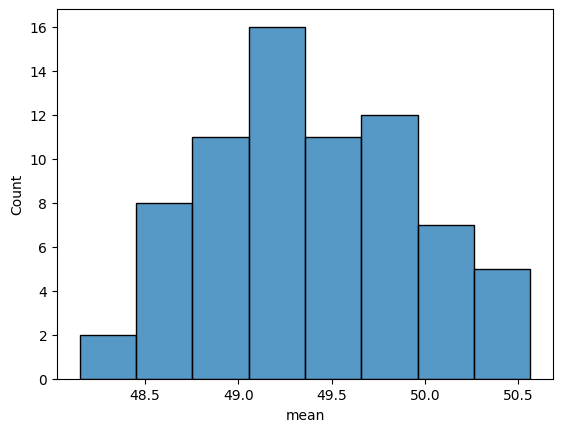

In [4]:
# gc content
gc_content = pd.read_table(f'{rna_qc}/mqc_fastqc_per_sequence_gc_content_plot_Percentages.txt', index_col=0)
gc_content['mean'] = [np.mean([float(col) * row[col] for col in gc_content.columns]) for _, row in gc_content.iterrows()]
sns.histplot(gc_content, x='mean')

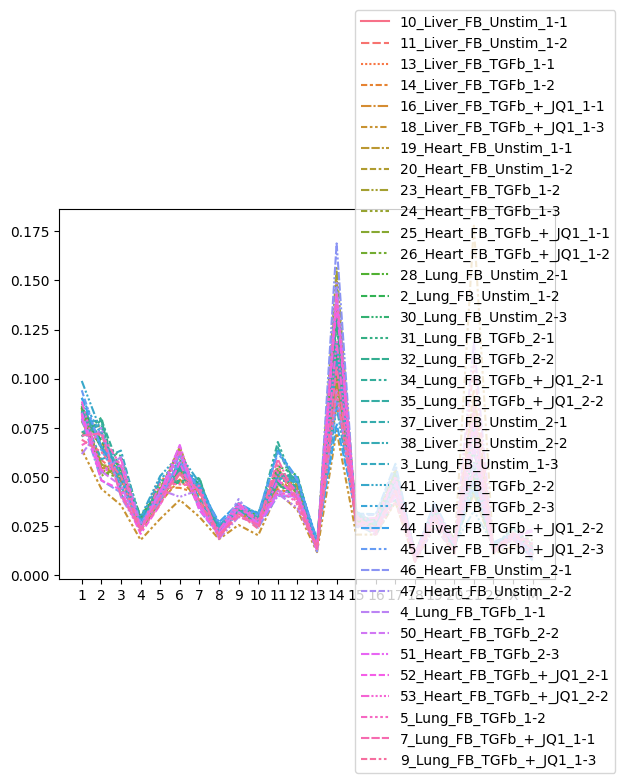

In [5]:
# mapped read coverage
mapped_reads = pd.read_table(f'{rna_qc}/mqc_samtools-idxstats-mapped-reads-plot_Normalised_Counts.txt', index_col=0)
mapped_reads.rename(columns = lambda c: c[3:], inplace=True)
sns.lineplot(mapped_reads.T.drop(index=['1_KI270713v1_random', '22_KI270733v1_random', 'Un_GL000220v1']))
plt.legend().remove()
plt.gcf().legend().set_loc('outside right')

<Axes: xlabel='pct_mapped', ylabel='Count'>

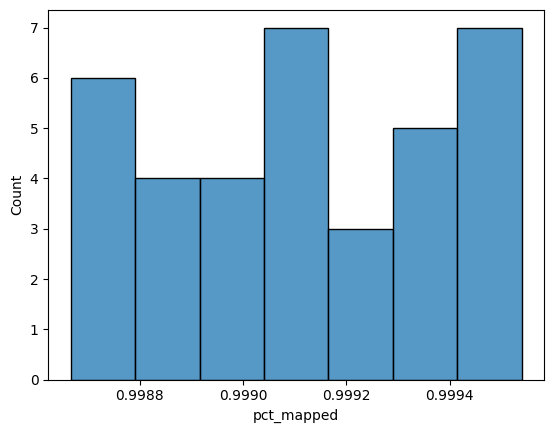

In [6]:
# total pct mapped reads
mapped_reads['pct_mapped'] = [sum(row) for _, row in mapped_reads.iterrows()]
sns.histplot(mapped_reads, x='pct_mapped')

<Axes: xlabel='Total reads', ylabel='Count'>

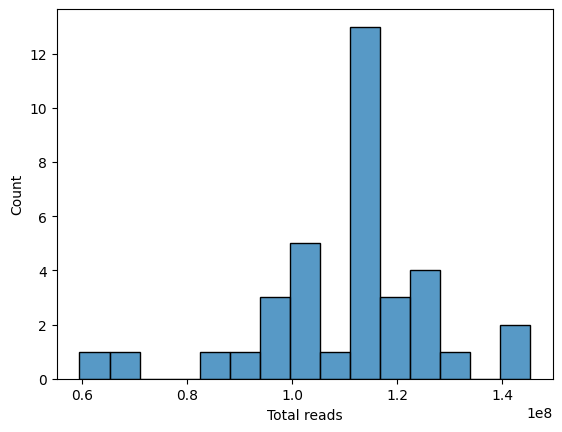

In [7]:
# Number of reads mapped
raw_mapped_reads = pd.read_table(f'{rna_qc}/mqc_samtools-idxstats-mapped-reads-plot_Raw_Counts.txt', index_col=0)
raw_mapped_reads['Total reads'] = raw_mapped_reads.aggregate('sum', axis=1)
sns.histplot(raw_mapped_reads, x = 'Total reads', bins=15)

### ATAC QC

In [8]:
atac_qc = f'{atac_datafolder}/fastqc'

In [9]:
sample_to_stats = {}
for file in os.listdir(atac_qc):
  if not os.path.isfile(f'{atac_qc}/{file}'):
    continue
  sample = file.split('_fastqc.')[0]
  sample_stats = {}
  with open(f'{atac_qc}/{file}', 'r') as qc:
    soup = BeautifulSoup(qc.read(), 'html.parser')
    for li in soup.find(name='ul').children:
      img, desc = li.children
      sample_stats[desc.text] = img.attrs['alt'][1:-1]
  sample_to_stats[sample] = sample_stats
atac_qc_df = pd.DataFrame(sample_to_stats).T

In [10]:
atac_qc_df.head()

,Basic Statistics,Per base sequence quality,Per tile sequence quality,Per sequence quality scores,Per base sequence content,Per sequence GC content,Per base N content,Sequence Length Distribution,Sequence Duplication Levels,Overrepresented sequences,Adapter Content
TGFB_JQ1_Heart_REP1_T1_2,PASS,PASS,PASS,PASS,FAIL,PASS,PASS,PASS,PASS,WARNING,WARNING
TGFB_Heart_REP2_T1_2,PASS,PASS,PASS,PASS,FAIL,PASS,PASS,PASS,PASS,WARNING,WARNING
TGFB_Lung_REP1_T1_2,PASS,PASS,PASS,PASS,FAIL,PASS,PASS,PASS,PASS,WARNING,PASS
TGFB_JQ1_Liver_REP1_T1_1,PASS,PASS,FAIL,PASS,FAIL,PASS,PASS,PASS,PASS,PASS,WARNING
TGFB_Lung_REP3_T1_1,PASS,PASS,FAIL,PASS,FAIL,PASS,PASS,PASS,PASS,PASS,WARNING


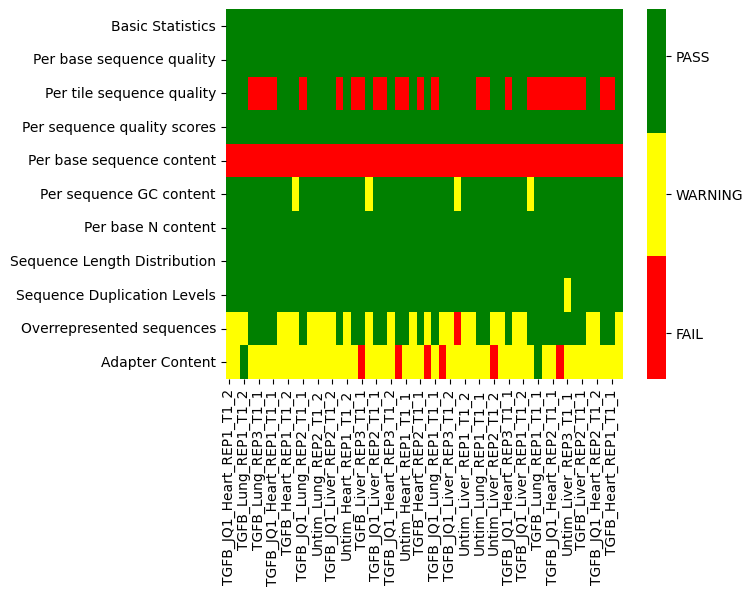

In [11]:
ax = sns.heatmap(atac_qc_df.T.map(lambda el: 2 if el == 'PASS' else 1 if el == 'WARNING' else 0), cmap=['red', 'yellow', 'green'])
colorbar = ax.collections[0].colorbar
colorbar.set_ticks(colorbar.get_ticks(minor=False)[1:9:3], labels = ['FAIL', 'WARNING', 'PASS'])

#### Diving into the samples

In [12]:
# Using muon (https://github.com/scverse/muon) for multiomic data structure
# First load into individual AnnData structures

rna_tpm = f'{rna_datafolder}/star_salmon/salmon.merged.transcript_tpm.tsv'
rna_df = pd.read_table(rna_tpm, index_col=0)
genes = rna_df['gene_id']
rna_df.drop(columns = 'gene_id', inplace=True)

rna_adata = ad.AnnData(rna_df.T)

In [13]:
rna_adata.var['gene'] = genes
rna_adata.obs['organ'] = [re.search(r"Heart|Lung|Liver", sample).group(0) for sample in rna_adata.obs_names]
rna_adata.obs['condition'] = [re.search(r"Unstim|TGFb(_._JQ1)?", sample).group(0).replace('_._', '+') for sample in rna_adata.obs_names]
rna_adata.obs['replicate'] = [re.search(r"[1-2]\.[1-3]", sample).group(0) for sample in rna_adata.obs_names]
rna_adata.obs_names = [f'{row['organ']}_{row['condition']}_REP{row['replicate']}' for _, row in rna_adata.obs.iterrows()]
rna_adata

AnnData object with n_obs × n_vars = 36 × 87398
    obs: 'organ', 'condition', 'replicate'
    var: 'gene'

In [14]:
palette = {'Unstim': '#2ca02c', 'TGFb': '#d62728', 'TGFb+JQ1': '#1f77b4'}
markers = {'Lung': 'o', 'Heart': '^', 'Liver': 's'}

<Axes: xlabel='organ', ylabel='Count'>

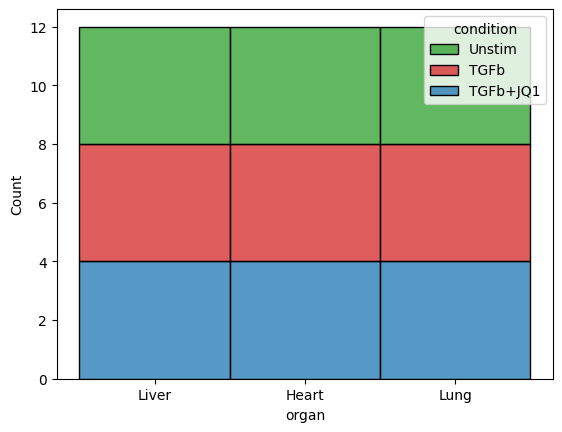

In [15]:
sns.histplot(rna_adata.obs, x='organ', hue='condition', multiple='stack', palette=palette, hue_order=palette.keys())

In [16]:
atac_peaks = f'{atac_datafolder}/bwa/merged_library/macs2/broad_peak/consensus/consensus_peaks.mLb.clN.featureCounts.txt'
atac_df = pd.read_table(atac_peaks, index_col=0, header=1)
atac_vars = atac_df[['Chr', 'Start', 'End', 'Strand', 'Length']]
atac_df.drop(columns = ['Chr', 'Start', 'End', 'Strand', 'Length'], inplace=True)

atac_adata = ad.AnnData(atac_df.T)

In [17]:
atac_adata.var = atac_vars
atac_adata.obs['organ'] = [re.search(r"Heart|Lung|Liver", sample).group(0) for sample in atac_adata.obs_names]
atac_adata.obs['condition'] = [re.search(r"Untim|TGFB(_JQ1)?", sample).group(0).replace('TGFB_', 'TGFB+').replace('TGFB', 'TGFb').replace('Untim', 'Unstim') for sample in atac_adata.obs_names]
atac_adata.obs['replicate'] = [re.search(r"REP[1-3]", sample).group(0) for sample in atac_adata.obs_names]
atac_adata.obs_names = [f'{row['organ']}_{row['condition']}_{row['replicate']}' for _, row in atac_adata.obs.iterrows()]
atac_adata

AnnData object with n_obs × n_vars = 26 × 164814
    obs: 'organ', 'condition', 'replicate'
    var: 'Chr', 'Start', 'End', 'Strand', 'Length'

<Axes: xlabel='organ', ylabel='Count'>

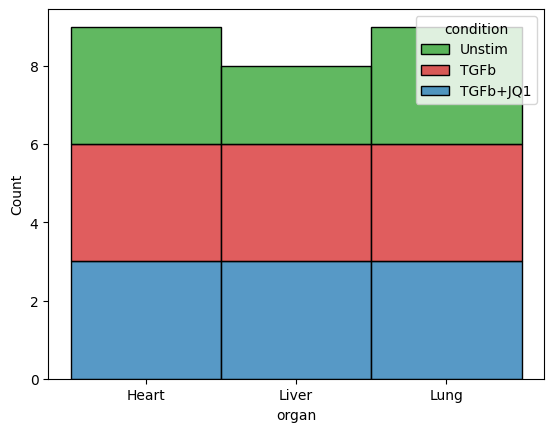

In [18]:
sns.histplot(atac_adata.obs, x='organ', hue='condition', multiple='stack', palette=palette, hue_order=palette.keys())

#### Principal Component Analysis

Are differences in gene expression and peaks primarily due to organ or condition?

In [19]:
def plot_organ_pca(adata: ad.AnnData, **kwargs) -> plt.Figure:
  fig, axs = plt.subplots(2, 2)
  for i, (organ, marker) in enumerate(markers.items()):
    sub = adata[adata.obs['organ'] == organ].copy()
    sc.pl.embedding(sub, 'pca', color='condition', palette=palette, s=50, title=organ, marker=marker, ax=axs[i % 2][int(i / 2)], show=False, use_raw=False, legend_loc='best' if i == 2 else None, **kwargs)
    sc.pl.embedding(sub, 'pca', color='condition', palette=palette, s=50, title='All', marker=marker, ax=axs[1][1], legend_loc=None, use_raw=False, show=False, **kwargs)

  plt.tight_layout()
  return fig

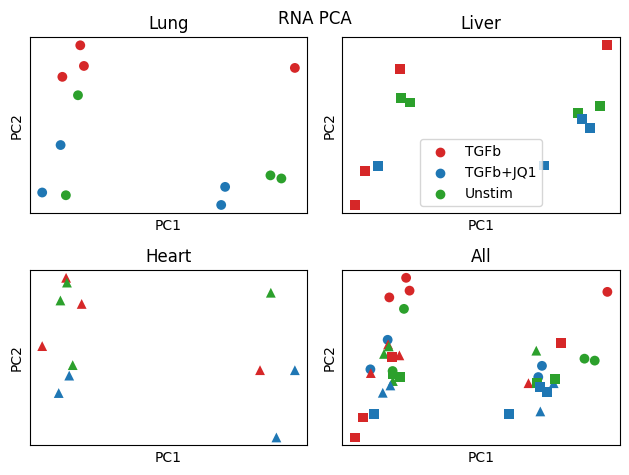

In [20]:
sc.pp.pca(rna_adata)
fig = plot_organ_pca(rna_adata)
fig.suptitle("RNA PCA")
plt.show()

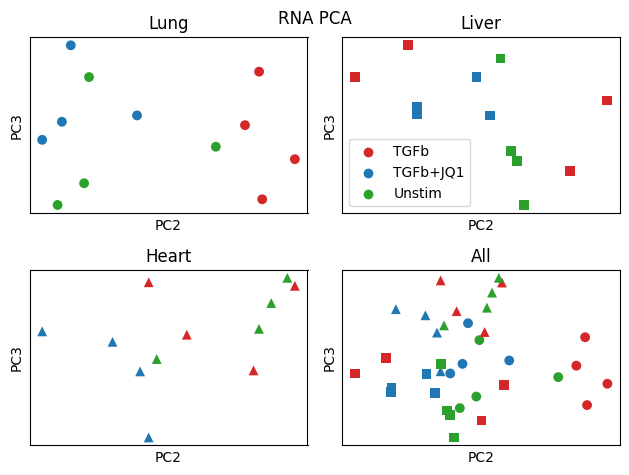

In [21]:
fig = plot_organ_pca(rna_adata, components='2,3')
fig.suptitle("RNA PCA")
plt.show()

In [22]:
### Regress out PC1
# PC1 seems to show stratification unrelated to condition/organ
rna_adata.obs['PC1'] = rna_adata.obsm['X_pca'][:, 0]
rna_adata_reg = sc.pp.regress_out(rna_adata, 'PC1', copy=True)
rna_adata.layers['post-regression'] = rna_adata_reg.X

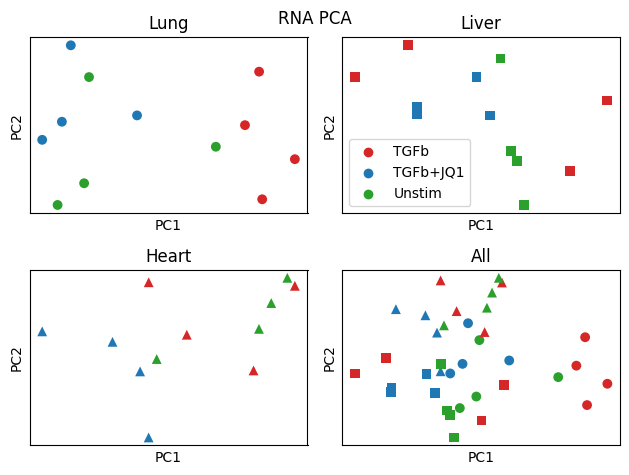

In [23]:
sc.pp.pca(rna_adata, layer='post-regression')
fig = plot_organ_pca(rna_adata, layer='post-regression')
fig.suptitle("RNA PCA")
plt.show()

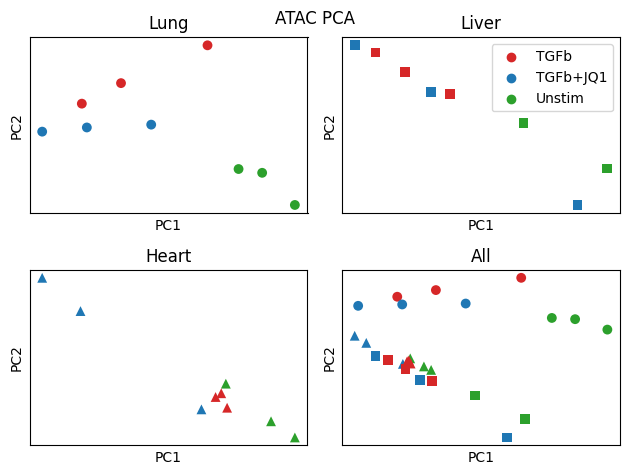

In [24]:
sc.pp.pca(atac_adata)
fig = plot_organ_pca(atac_adata)
fig.suptitle("ATAC PCA")
plt.show()

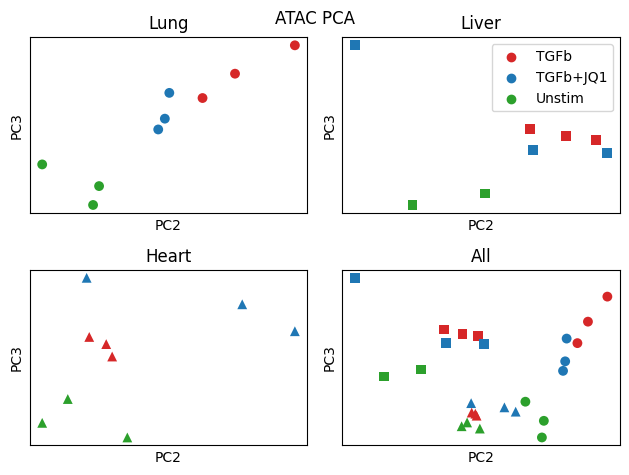

In [25]:
sc.pp.pca(atac_adata)
fig = plot_organ_pca(atac_adata, components='2,3')
fig.suptitle("ATAC PCA")
plt.show()

In [26]:
### Regress out PC1
# PC1 seems to show stratification unrelated to condition/organ
atac_adata.obs['PC1'] = atac_adata.obsm['X_pca'][:, 0]
atac_adata_reg = sc.pp.regress_out(atac_adata, 'PC1', copy=True)
atac_adata.layers['post-regression'] = atac_adata_reg.X

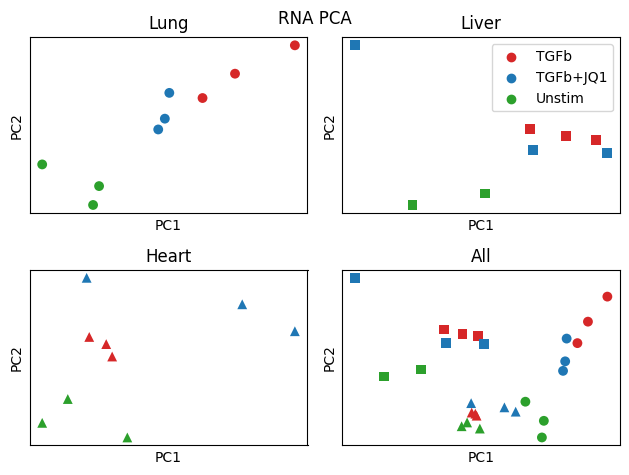

In [27]:
sc.pp.pca(atac_adata, layer='post-regression')
fig = plot_organ_pca(atac_adata, layer='post-regression')
fig.suptitle("RNA PCA")
plt.show()

In [29]:
# save files
atac_adata.write('./data/atac.h5ad')
rna_adata.write('./data/rna.h5ad')